# Build your custom image classifier using FastAI and OPEN-CE

*This notebook was copied and modified for this lab from this source https://github.com/fastai/course-v3*



Welcome to TechU Deep Learning Lab! 

For those of you who are using a Jupyter Notebook for the first time, you can learn about this useful tool in a tutorial we prepared specially for you; click `File`->`Open` now and click `jupyter_notebook_tutorial.ipynb`. [./jupyter_notebook_tutorial.ipynb](./jupyter_notebook_tutorial.ipynb)

In this lesson we will **build our first image classifier from scratch**, and see if we can achieve world-class results. Let's dive in!

Note, the most recent version of this lab is now using a build from OpenCE .  We have PyTorch 1.6 running with Fastai-version 2.  For more information about how to build the most recent deep learning frameworks for Power check out this repo.

https://github.com/open-ce/open-ce

In [1]:
%matplotlib inline
import os

#%reload_ext autoreload
#%autoreload 2
# For Using GPU's
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

## About our Class Environment

We import all the necessary packages. We are going to work with the [fastai V2 library](http://www.fast.ai/) which sits on top of [Pytorch 1.6](https://pytorch.org/). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

For this class, we are using Open-CE running in the **IBM Garage for Systems Cloud**, or CECC for short.  To get your own environment, simply browse to this website and request a Power8 or Power9 environment.

https://www.ibm.com/it-infrastructure/services/cecc-portal/web/Catalog

* Note : To get FastAI up and running we have a special setup script in our github repo ... 

https://github.ibm.com/vanstee/aicoc-ai-immersion/blob/master/FastAI/setup_fastai.sh

## Import FastAI Libraries

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
import os
import sys

# utility print function
def nprint(mystring) :
    print("**{}** : {}".format(sys._getframe(1).f_code.co_name,mystring))


## Project Configuration

This data structure below will hold all the settings for our class.  Its handy to have a simple dictionary contain all your project settings to keep organized.  We have include an override capability to these default settings so that you can customize your project. 


In [3]:
def getconfig(cfg_in={},base_dir="."):
    cfg = {}
    cfg["bs"] = 16
    cfg["base_dir"]  = base_dir
    cfg["image_dir"] = base_dir + "/class_images"
    cfg["classes"] = ["cars","busses","trucks"]
    cfg["num_images"] = {"train":200,"valid":0,"test":0}  # only use train for class. FastAI will autosplit
    cfg["d_partitions"] = list(cfg["num_images"].keys())                 
    cfg["jpeginfo"] =base_dir + "/jpeginfo"
   
    # overwrite configs if passed
    for (k,v) in cfg_in.items() :
        nprint("Overriding Config {}:{} with {}".format(k,cfg[k],v))
        cfg[k] = v
    return cfg

# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Build a Dataset on the Fly ..

Here we are going to build our own dataset !!  Think of 3 categories you would like to classify images.  In this example, we will use 
* people playing sports
* people holding money 
* people holding cups
* people playing with animals
* people on bikes

We will use an open source tool called **googliser** [https://github.com/teracow/googliser](https://github.com/teracow/googliser) to download our images from google images.

In [64]:
#################################################################################################
# @@ Students : Customize this cell with your custom classes for image classification
################################################################################################

# Overrides for lab

mycfg = {
     ## CLASS Enter your search terms below 
    "classes"     : ["people playing sports",
                     "people holding money",
                     "people holding cups",
                     "people playing with animals",
                     "people on bikes"], 
    "d_partitions": ["train"],
    "num_images"  : {"train":300,"valid":0,"test":0}  # only use train for class. FastAI will autosplit
  
}

# Setup Class Configuration
# base_dir=!pwd
# base_dir=base_dir[0]
base_dir = "/home/cecuser/5050/aicoc-ai-immersion/FastAI"
print("Base project directory : {}".format(base_dir))
cfg=getconfig(mycfg, base_dir)


Base project directory : /home/cecuser/5050/aicoc-ai-immersion/FastAI
**getconfig** : Overriding Config classes:['cars', 'busses', 'trucks'] with ['people playing sports', 'people holding money', 'people holding cups', 'people playing with animals', 'people on bikes']
**getconfig** : Overriding Config d_partitions:['train', 'valid', 'test'] with ['train']
**getconfig** : Overriding Config num_images:{'train': 200, 'valid': 0, 'test': 0} with {'train': 300, 'valid': 0, 'test': 0}


## Make Some Directories to hold our data 

FastAI is very flexible and help you label your image data in all sorts of ways.  The most stand  

You might have a bunch of images and a csv file with the labels.  You might have your images organized by folder with the folder name being the labels.  FastAI provid

To see all the supported methods check out this link..
https://docs.fast.ai/vision.data.html#ImageDataBunch.from_folder

For our class, we are going to organize our data by folder into something like this.. 
```
base/class_images/train
   people_holding_cups    people_on_bikes          people_playing_with_animals  
   people_holding_money   people_playing_sports           
```

In each folder we will have a bunch of \*.jpg files

### Build Directory Hierarchy

In [65]:

# Helpers to make directories
def class_folder_name(base,d_part,cls) :
    return base+"/"+d_part+"/"+ cls.replace(" ","_")

def makeDirIfNotExist(directory) :
    if not os.path.exists(directory):  
        nprint("Making directory {}".format(directory))
        os.makedirs(directory) 
    else :
        nprint("Directory {} already exists .. ".format(directory))

# Build directory hierarchy
#   [train|valid|test ]
#    -----------------> [class1 | class2 | class...]
#for d_part in cfg["d_partitions"] :
#    for cls in cfg["classes"] :
#        directory=class_folder_name(cfg['image_dir'],d_part,cls)
#        makeDirIfNotExist(directory)


## Install Googliser here.  
This handy utility will download our images from google images.  We will clone the repo from git.

In [66]:
# install googliser
def install_googliser():
    googliser_directory = cfg['base_dir']+"/googliser"
    if not os.path.exists(googliser_directory):  
        nprint("Installing Googliser here : {} ".format(googliser_directory))
        os.chdir(cfg['base_dir'])
        !git clone https://github.com/teracow/googliser
    else :
        nprint("Googliser already installed here : {} ".format(googliser_directory))

    googliser = cfg['base_dir']+"/googliser/googliser.sh"

    return googliser 
googliser = install_googliser()
!ls {googliser}

**install_googliser** : Googliser already installed here : /home/cecuser/5050/aicoc-ai-immersion/FastAI/googliser 
/home/cecuser/5050/aicoc-ai-immersion/FastAI/googliser/googliser.sh


## How many images should we grab ?


Luckily not too many.. it always depends on the project, but we are going to use a pre-training deep learning network when we perform training.  Since that network was already trained on over 1 million images, we don't need to supply too many for our task.  This is why transfer learning is so powerful!

In [67]:
cfg['num_images']

{'train': 300, 'valid': 0, 'test': 0}

In [68]:
from dask import delayed

#client = Client(n_workers=4)
from time import sleep

def inc(x):
    sleep(2)
    return x + 1
results=[]
data = [1, 2, 3, 4, 5, 6, 7, 8]
for x in data:
    y = delayed(inc)(x)
    results.append(y)

tot=sum(results)
%time tot.compute()

CPU times: user 6.12 ms, sys: 1.06 ms, total: 7.18 ms
Wall time: 2.01 s


44

## Dask to the rescue!

In [74]:
# The code below will download files to train folder only to avoid duplicate downloads.  
# We then move a few files over.  This can be done manually or programatically.  For our example
# we will let FastAI do the work for us!
def runcmd(cmd):
    !{cmd}
    return 1;

def download_images(cfg, force_download=False):
    # Download if directory does not exist or Force download = True
    results=[]
    
    if(not(os.path.exists(cfg['image_dir']))) :
       nprint("Image directory {} does not exist.  Downloading images..".format(cfg['image_dir']))
       force_download = True
    else :
        nprint("image dir exists : {}.  Not downloading again.  \nuse force_download=True to overwrite".format(cfg['image_dir']))
    
    if(force_download) :
        utility_dir = cfg['base_dir']
        for d_p in cfg["d_partitions"] : # train only for now ..
            for cls in cfg["classes"] :
                directory=class_folder_name(cfg['image_dir'],d_p,cls)
                makeDirIfNotExist(directory)

                current_dir =class_folder_name(cfg['image_dir'],d_p,cls)
                #os.chdir(current_dir)
                os.chdir(utility_dir)
                command = googliser + \
                          " --o {}".format(current_dir) +\
                          " --phrase \"{}\"".format(cls) + \
                          " --parallel 50 --upper-size 1000000 --lower-size 2000 " + \
                          " -n {}".format(cfg['num_images'][d_p]) + \
                          " --format jpg --timeout 15 --safesearch-off "
                nprint(command)
                results.append(delayed(runcmd)(command))
        results=sum(results)
        
        print(results.compute())
        nprint("Downloads complete!")
       
download_images(cfg,force_download=True)

# This will take ~5 mins depending on how many classes / images we are grabbing... 

**download_images** : image dir exists : /home/cecuser/5050/aicoc-ai-immersion/FastAI/class_images.  Not downloading again.  
use force_download=True to overwrite
**makeDirIfNotExist** : Directory /home/cecuser/5050/aicoc-ai-immersion/FastAI/class_images/train/people_playing_sports already exists .. 
**download_images** : /home/cecuser/5050/aicoc-ai-immersion/FastAI/googliser/googliser.sh --o /home/cecuser/5050/aicoc-ai-immersion/FastAI/class_images/train/people_playing_sports --phrase "people playing sports" --parallel 50 --upper-size 1000000 --lower-size 2000  -n 300 --format jpg --timeout 15 --safesearch-off 
**makeDirIfNotExist** : Directory /home/cecuser/5050/aicoc-ai-immersion/FastAI/class_images/train/people_holding_money already exists .. 
**download_images** : /home/cecuser/5050/aicoc-ai-immersion/FastAI/googliser/googliser.sh --o /home/cecuser/5050/aicoc-ai-immersion/FastAI/class_images/train/people_holding_money --phrase "people holding money" --parallel 50 --upper-size 1000

0/74 images OK, 6/50 are in progress0/89 images OK, 8/50 are in progress0/92 images OK, 5/50 are in progress 0/96 images OK0/74 images OK, 7/50 are in progress0/89 images OK, 9/50 are in progress0/92 images OK, 6/50 are in progress0/96 images OK, 1/50 are in progress0/74 images OK, 8/50 are in progress0/89 images OK, 10/50 are in progress0/92 images OK, 7/50 are in progress     links:0/74 images OK, 9/50 are in progres0/89 images OK, 11/50 are in progress0/92 images OK, 8/50 are in progress0/96 images OK, 2/50 are in progress0/74 images OK, 10/50 are in progres0/89 images OK, 12/50 are in progress0/96 images OK, 3/50 are in progres0/74 images OK, 11/50 are in progres0/89 images OK, 13/50 are in progress0/92 images OK, 9/50 are in progress0/96 images OK, 4/50 are in progres0/74 images OK, 11/50 are in progress and 2 have failed1/92 images OK, 9/50 are in progress 118 


 download1/89 images OK, 14/50 are in progress0/96 images OK, 5/50 are in progre0/74 images OK, 10/50 are in progress and 3 have failed0/96 images OK, 6/50 are in progress 1/92 images OK, 9/50 are in progress and 2 have faile1/89 images OK, 14/50 are in progress and 1 have failed 0/118 images O0/74 images OK, 11/50 are in progress and 3 have faile1/89 images OK, 15/50 are in progress and 1 have failed0/96 images OK, 7/50 are in progres0/118 images OK, 1/50 are in progress1/92 images OK, 10/50 are in progress and 2 have faile1/74 images OK, 11/50 are in progress and 3 have failed0/96 images OK, 8/50 are in progres2/89 images OK, 15/50 are in progress and 1 have faile0/118 images OK, 2/50 are in progres2/92 images OK, 10/50 are in progress and 2 have faile1/74 images OK, 12/50 are in progress and 3 have failed0/96 images OK, 9/50 are in progres0/118 images OK, 3/50 are in progres4/92 images OK, 7/50 are in progress and 4 have faile4/89 images OK, 15/50 are in progress and 1 have faile2/7

11/96 images OK, 11/50 are in progress and 4 have faile15/74 images OK, 9/50 are in progress and 9 have failed21/89 images OK, 13/50 are in progress and 2 have failed7/118 images OK, 15/50 are in progres14/92 images OK, 10/50 are in progress and 8 have failed21/89 images OK, 14/50 are in progress and 2 have failed11/96 images OK, 12/50 are in progress and 4 have faile15/74 images OK, 10/50 are in progress and 9 have failed7/118 images OK, 16/50 are in progress15/92 images OK, 10/50 are in progress and 8 have failed15/96 images OK, 10/50 are in progress and 4 have failed22/89 images OK, 13/50 are in progress and 3 have failed16/74 images OK, 10/50 are in progress and 9 have failed16/92 images OK, 9/50 are in progress and 9 have failed11/118 images OK, 14/50 are in progress23/89 images OK, 13/50 are in progress and 3 have failed17/74 images OK, 10/50 are in progress and 9 have faile13/118 images OK, 12/50 are in progress16/96 images OK, 9/50 are in progress and 4 have faile16/92 images 

27/74 images OK, 13/50 are in progress and 12 have failed30/96 images OK, 10/50 are in progress and 5 have faile27/74 images OK, 14/50 are in progress and 12 have failed30/118 images OK, 6/50 are in progress and 4 have failed31/96 images OK, 10/50 are in progress and 5 have faile28/92 images OK, 13/50 are in progress and 11 have failed40/89 images OK, 14/50 are in progress and 3 have faile27/74 images OK, 15/50 are in progress and 12 have failed30/118 images OK, 7/50 are in progress and 4 have failed32/96 images OK, 9/50 are in progress and 6 have failed30/118 images OK, 8/50 are in progress and 4 have failed40/89 images OK, 15/50 are in progress and 3 have faile28/92 images OK, 14/50 are in progress and 11 have faile28/74 images OK, 15/50 are in progress and 12 have faile32/96 images OK, 10/50 are in progress and 6 have failed41/89 images OK, 15/50 are in progress and 3 have fail29/74 images OK, 15/50 are in progress and 12 have failed 30/118 images OK, 9/50 are in progress and 4 have

47/96 images OK, 9/50 are in progress and 7 have faile44/92 images OK, 13/50 are in progress and 13 have faile41/118 images OK, 13/50 are in progress and 5 have failed55/89 images OK, 15/50 are in progress and 4 have failed55/89 images OK, 16/50 are in progress and 4 have faile44/74 images OK, 13/50 are in progress and 15 have faile47/96 images OK, 10/50 are in progress and 7 have faile43/118 images OK, 12/50 are in progress and 5 have faile44/92 images OK, 14/50 are in progress and 13 have faile45/74 images OK, 13/50 are in progress and 15 have faile44/118 images OK, 12/50 are in progress and 5 have failed56/89 images OK, 16/50 are in progress and 4 have faile45/74 images OK, 14/50 are in progress and 15 have failed47/96 images OK, 11/50 are in progress and 7 have faile44/92 images OK, 15/50 are in progress and 13 have failed56/89 images OK, 16/50 are in progress and 5 have faile45/118 images OK, 12/50 are in progress and 5 have faile45/92 images OK, 15/50 are in progress and 13 have 

64/96 images OK, 11/50 are in progress and 7 have faile59/118 images OK, 12/50 are in progress and 8 have faile60/92 images OK, 13/50 are in progress and 17 have failed66/96 images OK, 10/50 are in progress and 7 have faile59/118 images OK, 13/50 are in progress and 8 have failed71/89 images OK, 13/50 are in progress and 6 have failed67/96 images OK, 10/50 are in progress and 7 have failed52/74 images OK, 5/50 are in progress and 17 have failed72/89 images OK, 11/50 are in progress and 6 have faile60/92 images OK, 14/50 are in progress and 17 have faile60/118 images OK, 13/50 are in progress and 8 have failed67/96 images OK, 11/50 are in progress and 7 have failed53/74 images OK, 4/50 are in progress and 17 have faile62/92 images OK, 14/50 are in progress and 17 have faile62/118 images OK, 13/50 are in progress and 8 have fail68/96 images OK, 11/50 are in progress and 7 have failed 62/92 images OK, 13/50 are in progress and 17 have faile64/92 images OK, 12/50 are in progress and 17 hav

90/118 images OK, 19/50 are in progress and 9 have faile91/118 images OK, 18/50 are in progress and 9 have faile87/96 images OK, 1/50 are in progress and 8 have faile92/118 images OK, 17/50 are in progress and 9 have faile94/118 images OK, 16/50 are in progress and 9 have faile94/118 images OK, 15/50 are in progress and 9 have faile96/118 images OK, 13/50 are in progress and 9 have faile88/96 images OK, 1/50 are in progress and 8 have faile97/118 images OK, 13/50 are in progress and 9 have faile88/96 images OK and 8 failed                         97/118 images OK, 12/50 are in progress and 9 have failed links list exhausted!
98/118 images OK, 11/50 are in progress and 9 have faile99/118 images OK, 10/50 are in progress and 9 have faile100/118 images OK, 9/50 are in progress and 9 have faile101/118 images OK, 8/50 are in progress and 9 have faile102/118 images OK, 8/50 are in progress and 9 have faile102/118 images OK, 7/50 are in progress and 9 have faile103/118 images OK, 6/50 are in 

## Clean up downloaded images that are not proper jpeg format ..

In [75]:
# clean with jpeginfo! 
def clean_up_bad_images(cfg):
    os.chdir(cfg['image_dir'])
    nprint("Search for Error files in {}......".format(cfg['image_dir']))
    # handle both jpg //jpeg files that are malformed
    for ext in ["jpg","jpeg"] :
        command = "find . -name \"*.{}\"".format(ext) + \
          " | xargs -i {}".format(cfg["jpeginfo"]) + \
          " -c {} | grep ERROR"
        nprint("Running command : {}".format(command))
        !{command}
        nprint("Removing any error files listed above")
        command = command + ' | cut -d " " -f1 | xargs -i rm {} '
        nprint("Running command : {}".format(command))
        !{command}
        nprint("Done")
    # get rid of png /webp
    for ext in ["png", "webp"]:
        command = "find . -name \"*.{}\"".format(ext) + \
            " | xargs -i rm -f {}"
        nprint("Running command : {}".format(command))
        !{command}
        
clean_up_bad_images(cfg)

# find . -name "*.jpg," | xargs -i ./jpeginfo -c {}
# find . -name "*.jpg" | xargs -i ./jpeginfo -c {} | grep ERROR | cut -d " " -f1 | xargs -i rm {}

**clean_up_bad_images** : Search for Error files in /home/cecuser/5050/aicoc-ai-immersion/FastAI/class_images......
**clean_up_bad_images** : Running command : find . -name "*.jpg" | xargs -i /home/cecuser/5050/aicoc-ai-immersion/FastAI/jpeginfo -c {} | grep ERROR
./train/people_holding_money/image(0024).jpg  Not a JPEG file: starts with 0x52 0x49  [ERROR]
./train/people_holding_money/image(0045).jpg  Not a JPEG file: starts with 0x52 0x49  [ERROR]
./train/people_holding_money/image(0052).jpg  Not a JPEG file: starts with 0x52 0x49  [ERROR]
./train/people_holding_money/image(0070).jpg  Not a JPEG file: starts with 0x52 0x49  [ERROR]
./train/people_holding_money/image(0081).jpg  Not a JPEG file: starts with 0x52 0x49  [ERROR]
./train/people_holding_cups/image(0018).jpg  Not a JPEG file: starts with 0x52 0x49  [ERROR]
./train/people_holding_cups/image(0037).jpg  Not a JPEG file: starts with 0x52 0x49  [ERROR]
./train/people_holding_cups/image(0106).jpg  Not a JPEG file: starts with 0x52 

In [76]:
#path = untar_data(URLs.PETS); path
path = Path(cfg['image_dir'])

In [77]:
path.ls()
#cfg['image_dir']

(#1) [Path('/home/cecuser/5050/aicoc-ai-immersion/FastAI/class_images/train')]

## Data Processing and Understanding

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, **labels are stored in the name of the folder containing the file**. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataLoaders.from_folder` gets the labels from the folder name.

## Create Datasets / Dataloaders
Fastai has a number of methods to create a 

Datasets and Dataloaders (notice the 's' on the class names) are FastAI abstractions to help us load and process the image data.  In general these classes support all sorts of datatype like image / tabular/ and text.  

The main goal of Datasets / Dataloaders is to help hold all the data (train / validataion / test) in a single data structure and also allow us to easily transform and create batches for training.  

The creation of datasets / dataloaders is based on using something called the datablock API.  This is a set of tools to help you build out instances of the datasets/dataloaders classes.

For a full treatment of dataloaders / datasets/ datablock API topic see the documenation here -> https://docs.fast.ai/tutorial.datablock

This notebook was built referencing the documentation link above.

In [78]:
# FastAI makes use of the python Pathlib library.  here are a couple examples of how this works.

# get_image_files is a FastAI utility to grab all images from a provided base path


In [79]:
import fastai.data.all as fda
import fastai.vision.all as fva

fnames = fda.get_image_files(path)

# Some Path Experiments
# This will be useful for our label func ..
# https://docs.python.org/3/library/pathlib.html
fname = fnames[0]
print(type(fname))
print(fname)
print("Name : {}".format(fname.name))
print("Parent : {}".format(fname.parent))
print("Suffix : {}".format(fname.suffix))

<class 'pathlib.PosixPath'>
/home/cecuser/5050/aicoc-ai-immersion/FastAI/class_images/train/people_playing_sports/image(0002).jpg
Name : image(0002).jpg
Parent : /home/cecuser/5050/aicoc-ai-immersion/FastAI/class_images/train/people_playing_sports
Suffix : .jpg


In [80]:
## Method 1 use DataBlock API
# References
# https://docs.fast.ai/tutorial.datablock
# https://docs.fast.ai/data.transforms#RandomSplitter

In [81]:
# Here we create our own label function to grab the name of the folder that holds the label.
def label_func(fname):
    # this returns the name of the folder the file is in.  This is the label!
    return str(fname.parent).split('/')[-1]

# Example
print("Full file name  : {}".format(fname))
print("Label extracted : {}".format(label_func(fname)))

Full file name  : /home/cecuser/5050/aicoc-ai-immersion/FastAI/class_images/train/people_playing_sports/image(0002).jpg
Label extracted : people_playing_sports


In [82]:
# aug+transforms 
# https://docs.fast.ai/vision.augment#aug_transforms
dblockv1 = fda.DataBlock(blocks    = (fva.ImageBlock, fda.CategoryBlock), # Tell datablock api we have images / categories
                   get_items = fda.get_image_files, # this recurses the datablock directory that is provided
                   get_y     = label_func, # applies the label
                   splitter  = fda.RandomSplitter(), # splitting func
                   item_tfms = fva.Resize(400),
                   batch_tfms=[*fva.aug_transforms(size=224, min_scale=0.85), fva.Normalize.from_stats(*fva.imagenet_stats)])


dsets_v1 = dblockv1.datasets(path)
print("Example X,y : {}".format(dsets_v1.train[0]))
print("labels in this dataset : {}".format(dsets_v1.vocab))

Example X,y : (PILImage mode=RGB size=680x1023, TensorCategory(2))
labels in this dataset : ['people_holding_cups', 'people_holding_money', 'people_on_bikes', 'people_playing_sports', 'people_playing_with_animals']


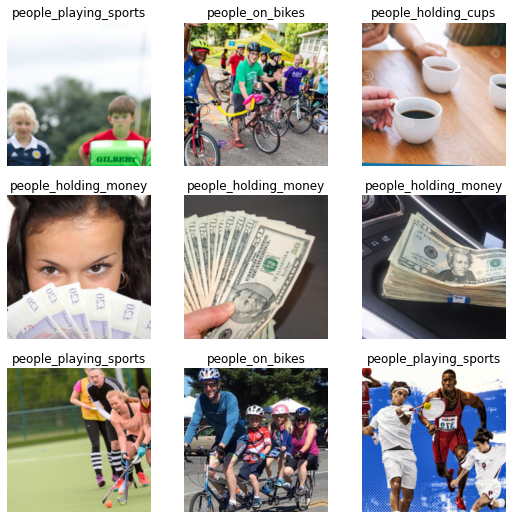

In [83]:
# Display a sample of images ...
bs=64
dls = dblockv1.dataloaders(path,bs=bs)
dls.show_batch()

In [84]:
dblockv1.summary(path)

Setting-up type transforms pipelines
Found 365 items
2 datasets of sizes 292,73
Setting up Pipeline: PILBase.create
Setting up Pipeline: label_func -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/cecuser/5050/aicoc-ai-immersion/FastAI/class_images/train/people_holding_money/image(0066).jpg
    applying PILBase.create gives
      PILImage mode=RGB size=1300x866
  Pipeline: label_func -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /home/cecuser/5050/aicoc-ai-immersion/FastAI/class_images/train/people_holding_money/image(0066).jpg
    applying label_func gives
      people_holding_money
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(1)

Final sample: (PILImage mode=RGB size=1300x866, TensorCategory(1))


Setting up after_item: Pipeline: Resize -- {'size': (400, 400), 'method': 'crop', 'pad_mode': 'refle

In [39]:
# Alternative Method using FastAI built-in ImageDataLoaders [use above for class]
# bs = 64
# 
# # https://docs.fast.ai/vision.data#ImageDataLoaders.from_folder
# dlsv2 = ImageDataLoaders.from_folder(
#     path, 
#     item_tfms=Resize(460), 
#     bs=bs,
#     valid_pct=0.20,
#     batch_tfms=[*aug_transforms(max_lighting=0.5, size=224, min_scale=0.65), Normalize.from_stats(*imagenet_stats)])
# dlsv2.show_batch(max_n=9, figsize=(9,9))

### Compare Traing set vs Validation set Label Distribution

In [85]:
import collections
import numpy as np
import pandas as pd

def get_label_distribution(dls) :
    # *dls.xxx_ds returns tuples split into parts..zip reassembles into x/y vectors ...
    x,y = zip(*dls.train_ds)
    xv,yv = zip(*dls.valid_ds)
    
    # this creates our labels list.  basically transform fastai.tensor object to a simple list of ints 
    y_labels = list(map(lambda a : a.item() ,y))
    yv_labels = list(map(lambda a : a.item() ,yv))
    
    # Create a dataframe of categorical counts
    df=pd.DataFrame([
        pd.Series(y_labels).value_counts(),
        pd.Series(yv_labels).value_counts()
       ]).T
    # Add percentages..
    df.columns = ["train","valid"]
    df["train_pct"] = df["train"]/df["train"].sum()
    df["valid_pct"] = df["valid"]/df["valid"].sum()
    df["labels"] = pd.Series(dls.vocab)
    display(df)
    # If you did want to plot, look at this
    # https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/categorical_variables.html

type(dls.train_ds)
type(dls.valid_ds)

print("Num Images in Training Set : {}".format(len(dls.train_ds)))
print("Num Images in Validation Set : {}".format(len(dls.valid_ds)))

get_label_distribution(dls)


Num Images in Training Set : 292
Num Images in Validation Set : 73


,train,valid,train_pct,valid_pct,labels
0,82,16,0.280822,0.219178,people_holding_cups
1,61,15,0.208904,0.205479,people_holding_money
2,51,15,0.174658,0.205479,people_on_bikes
3,43,8,0.147260,0.109589,people_playing_sports
4,55,19,0.188356,0.260274,people_playing_with_animals


Analysis .. 
Make sure prior to the run you are ok with the class balance in the test vs validation.  Class imbalance between these 2 sets are important for good results.  I like to look for 2 things

1. Each class has a similar number of images ..
2. The percentage of images in training for a certain class = percentage of images for the validation .. 


## Training using Transfer Learning : resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? 

Not to worry, check out the FastAI course videos for a deep dive [https://course.fast.ai/](https://course.fast.ai/). For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 5 outputs).


In [86]:
#create learner
learn = fva.cnn_learner(dls, fva.resnet34, metrics=error_rate).to_fp16()

In [111]:
# Lets see a summary of the model
learn.model

Sequential(
  (0): Sequential(
    (0): ConvLayer(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): ConvLayer(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): ConvLayer(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): ResBlock(
        (convpath): Sequential(
          (0): ConvLayer(
            (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(64, ep

In [112]:
# Lets Train a little to see where we stand. 
# Fit_one_cycle uses cyclical learning rates
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.539097,2.703850,0.739726,00:07
1,2.579716,6.767188,0.794521,00:06
2,2.202743,7.111098,0.780822,00:06
3,1.870884,4.113136,0.684932,00:05


SuggestedLRs(lr_min=0.005754399299621582, lr_steep=2.75422871709452e-06)

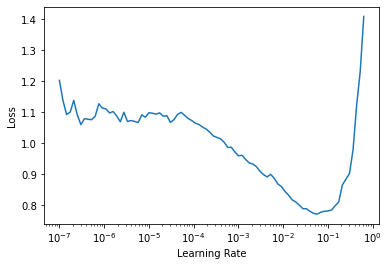

In [113]:
# Lets run lr_find to find the optimal learning rates
learn.lr_find()

In [115]:
# Run 5 epochs (can do more if still getting better train / val)
# FILL IN THE RANGE BASE ON YOUR LRFIND RESULT
learn.fit_one_cycle(5, max_lr=slice(8e-4,2e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.785725,0.878350,0.246575,00:07
1,0.690549,0.867909,0.342466,00:06
2,0.632032,0.656045,0.273973,00:06
3,0.572048,0.599262,0.246575,00:05
4,0.539921,0.574173,0.246575,00:06


In [116]:
# Save out our current results ..
learn.save('stage-1')

Path('models/stage-1.pth')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, if we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [117]:
interp = fva.ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(dls.valid_ds)==len(losses)==len(idxs)

True

In [118]:
fda.doc(interp.plot_top_losses)

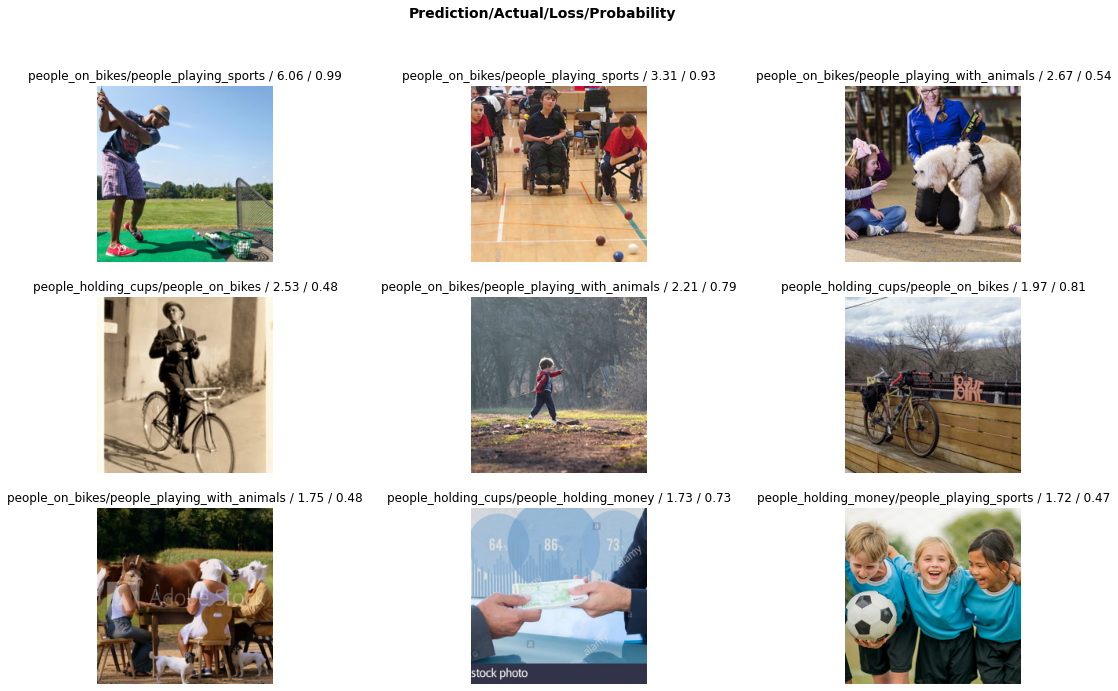

In [119]:
interp.plot_top_losses(9, figsize=(19,11))

array([[14,  1,  1,  0,  0],
       [ 3, 12,  0,  0,  0],
       [ 3,  0, 12,  0,  0],
       [ 0,  1,  3,  3,  1],
       [ 1,  0,  4,  0, 14]])

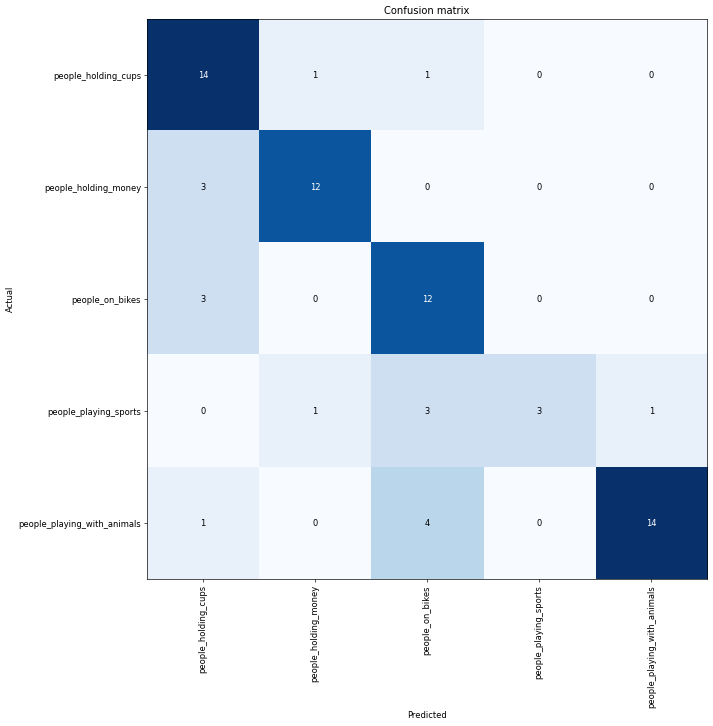

In [120]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
interp.confusion_matrix()

In [121]:
interp.most_confused(min_val=2)

[('people_playing_with_animals', 'people_on_bikes', 4),
 ('people_holding_money', 'people_holding_cups', 3),
 ('people_on_bikes', 'people_holding_cups', 3),
 ('people_playing_sports', 'people_on_bikes', 3)]

In [123]:
interp.print_classification_report()

                             precision    recall  f1-score   support

        people_holding_cups       0.67      0.88      0.76        16
       people_holding_money       0.86      0.80      0.83        15
            people_on_bikes       0.60      0.80      0.69        15
      people_playing_sports       1.00      0.38      0.55         8
people_playing_with_animals       0.93      0.74      0.82        19

                   accuracy                           0.75        73
                  macro avg       0.81      0.72      0.73        73
               weighted avg       0.80      0.75      0.75        73



## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [124]:
learn.freeze_to(-2)

In [125]:
learn.summary()

Sequential (Input shape: ['64 x 3 x 224 x 224'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 32 x 112 x 112  864        False     
________________________________________________________________
BatchNorm2d          64 x 32 x 112 x 112  64         True      
________________________________________________________________
ReLU                 64 x 32 x 112 x 112  0          False     
________________________________________________________________
Conv2d               64 x 32 x 112 x 112  9,216      False     
________________________________________________________________
BatchNorm2d          64 x 32 x 112 x 112  64         True      
________________________________________________________________
ReLU                 64 x 32 x 112 x 112  0          False     
________________________________________________________________
Conv2d               64 x 64 x 112 x 112  18,432     False     
_________________________________________________

In [126]:
#learn.fit_one_cycle(8)
learn.fit_one_cycle(5, max_lr=slice(8e-4,2e-2))

epoch,train_loss,valid_loss,error_rate,time
0,0.352835,1.248264,0.328767,00:06
1,0.386766,None,None,00:05


KeyboardInterrupt: 

In [104]:
learn.save('stage-2')
#learn.load('stage-1');
#learn.unfreeze(-2)
#learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3))

Path('models/stage-2.pth')

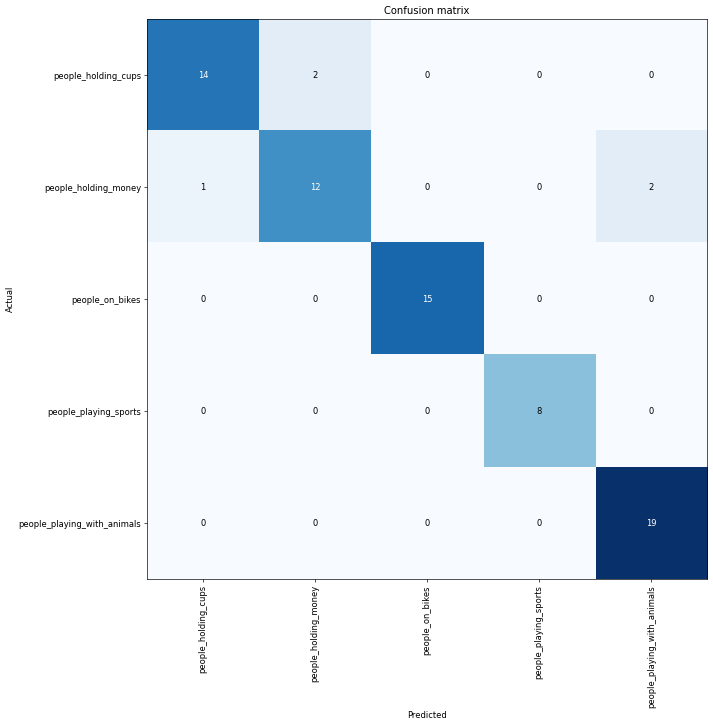

In [107]:
interp = fva.ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [108]:
interp.print_classification_report()

                             precision    recall  f1-score   support

        people_holding_cups       0.93      0.88      0.90        16
       people_holding_money       0.86      0.80      0.83        15
            people_on_bikes       1.00      1.00      1.00        15
      people_playing_sports       1.00      1.00      1.00         8
people_playing_with_animals       0.90      1.00      0.95        19

                   accuracy                           0.93        73
                  macro avg       0.94      0.93      0.94        73
               weighted avg       0.93      0.93      0.93        73



That's a pretty accurate model!

##  Optional Assignment Training: xresnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. The details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf) and this post https://towardsdatascience.com/xresnet-from-scratch-in-pytorch-e64e309af722.

Basically, xresnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. Recommendations 
* let's us use larger images too, 
* reduce the batch size a bit since otherwise this larger network will require more GPU memory

Can you redo the training above with a different pre-trained model ???  See this page for some ideas

https://docs.fast.ai/vision.models.xresnet

copy the above code below, or maybe make a copy of your notebook and try it out...

In [110]:
# example !
learn = fva.cnn_learner(dls, fva.xresnet50, metrics=error_rate).to_fp16()

# Advanced Example :  Integration with Maximo Visual Insights

So you want to train on some data that maybe you labelled in another tool ?  No problem.  Here we show how to read in data exported from Maximo Visual Insights and classify using FastAI.

For our IBM Maximo Visual Insights Example, we can just run a nice utility to reformat the output.  For convenience, we added a **Bananas Dataset** to our repo to play with ..

In [127]:
os.chdir(cfg["base_dir"])
!ls *.zip

Bananas.zip


## Unzip our bananas data and convert to images in sub-directories

When you export data from IVI, you get a single zip file.  When you unzip this file, you get a singular directory with a metadata file called prop.json.  We have a utility that will read that prop.json and create a new directory with sorted images... lets see how this works

In [129]:
# unzip the Bananas.zip to /tmp/bananas_ivi directory
!sudo yum install -y unzip
!unzip -o -d /tmp Bananas.zip 

Loaded plugins: nvidia, search-disabled-repos
cuda-10-2-local-10.2.89-440.33.01                        | 2.6 kB     00:00     
local-rhn-server-epel                                    | 3.0 kB     00:00     
local-rhn-server-extras                                  | 2.9 kB     00:00     
local-rhn-server-iso-media                               | 4.3 kB     00:00     
local-rhn-server-optional                                | 2.9 kB     00:00     
local-rhn-server-os                                      | 2.9 kB     00:00     
local-rhn-server-rhscl                                   | 2.9 kB     00:00     
local-rhn-server-supplementary                           | 2.9 kB     00:00     
nvidia-driver-local-440.64.00                            | 2.5 kB     00:00     
powerai-epel                                             | 3.0 kB     00:00     
powerai-extras                                           | 2.9 kB     00:00     
powerai-optional                                         | 2.9 

In [131]:
# Now download our handy Maximo dataset conversion script !
# Maximo Visual Insights exports data in a unique format with image files
# and a json file containing label metadata.  Our script reads this in
# and converts that into a nice directory structure with the folder
# containing the class label
!git clone https://github.com/dustinvanstee/powerai-vision-utils.git

fatal: destination path 'powerai-vision-utils' already exists and is not an empty directory.


In [138]:
#!conda install -y scikit-learn # dependency to run our utility ..
!python powerai-vision-utils/reorganize_exported_dataset.py --directory_in /tmp/Bananas --directory_out /tmp/bananas_fastai/train

directory_in /tmp/Bananas
directory_out /tmp/bananas_fastai/train
classes : ['ripe', 'yellow', 'black', 'overripe', 'green']
/tmp/bananas_fastai/train/ripe
/tmp/bananas_fastai/train/yellow
/tmp/bananas_fastai/train/black
/tmp/bananas_fastai/train/overripe
/tmp/bananas_fastai/train/green
ofn : RP3.jpg
ofn_root : RP3
ofn_extention jpg
augm : na
newfile : RP3_na_da10b0f2.jpg
fin : /tmp/Bananas/ace685e2-9dd4-45ef-803c-30d8da10b0f2.jpg
fout : /tmp/bananas_fastai/train/ripe/RP3_na_da10b0f2.jpg
ofn : RP8.jpg
ofn_root : RP8
ofn_extention jpg
augm : na
newfile : RP8_na_9ddeceaf.jpg
fin : /tmp/Bananas/50a24336-4d89-490b-af40-0be49ddeceaf.jpg
fout : /tmp/bananas_fastai/train/ripe/RP8_na_9ddeceaf.jpg
ofn : RP9.jpg
ofn_root : RP9
ofn_extention jpg
augm : na
newfile : RP9_na_76e428b7.jpg
fin : /tmp/Bananas/dd504896-cefd-4481-b59e-57dd76e428b7.jpg
fout : /tmp/bananas_fastai/train/ripe/RP9_na_76e428b7.jpg
ofn : RP11.jpg
ofn_root : RP11
ofn_extention jpg
augm : na
newfile : RP11_na_1d36f1d7.jpg
fin : /

ofn : G6.jpg
ofn_root : G6
ofn_extention jpg
augm : na
newfile : G6_na_ee229116.jpg
fin : /tmp/Bananas/41e3da71-0f1a-4ee6-8d71-8d25ee229116.jpg
fout : /tmp/bananas_fastai/train/green/G6_na_ee229116.jpg
ofn : RP91.jpg
ofn_root : RP91
ofn_extention jpg
augm : na
newfile : RP91_na_d511fed7.jpg
fin : /tmp/Bananas/b4942267-b824-441e-baf3-e72cd511fed7.jpg
fout : /tmp/bananas_fastai/train/ripe/RP91_na_d511fed7.jpg
ofn : BY41.jpg
ofn_root : BY41
ofn_extention jpg
augm : na
newfile : BY41_na_b41169fc.jpg
fin : /tmp/Bananas/d98737ea-b7a1-4f20-b14d-d9a5b41169fc.jpg
fout : /tmp/bananas_fastai/train/yellow/BY41_na_b41169fc.jpg
ofn : BY22.jpg
ofn_root : BY22
ofn_extention jpg
augm : na
newfile : BY22_na_2ad62018.jpg
fin : /tmp/Bananas/d2384635-4df0-4003-92ab-c98c2ad62018.jpg
fout : /tmp/bananas_fastai/train/yellow/BY22_na_2ad62018.jpg
ofn : RP55.jpg
ofn_root : RP55
ofn_extention jpg
augm : na
newfile : RP55_na_b40a4a44.jpg
fin : /tmp/Bananas/76bd5270-554f-4f6c-8226-4e8eb40a4a44.jpg
fout : /tmp/banan

In [139]:
!ls /tmp/bananas_fastai/train

black  green  overripe	ripe  yellow


In [140]:
# New project config!
mycfg = {
    "image_dir" : "/tmp/bananas_fastai",
    "classes":["black","green","overripe","yellow","ripe"],  ## <<- CLASS Enter your search terms here 
    "d_partitions":["train"],
}
ivicfg=getconfig(mycfg)


**getconfig** : Overriding Config image_dir:./class_images with /tmp/bananas_fastai
**getconfig** : Overriding Config classes:['cars', 'busses', 'trucks'] with ['black', 'green', 'overripe', 'yellow', 'ripe']
**getconfig** : Overriding Config d_partitions:['train', 'valid', 'test'] with ['train']


In [141]:
# New Image Path ..
path = Path(ivicfg["image_dir"])
path

Path('/tmp/bananas_fastai')

In [142]:
!ls /tmp/bananas_fastai/train

black  green  overripe	ripe  yellow


## Define Databunch

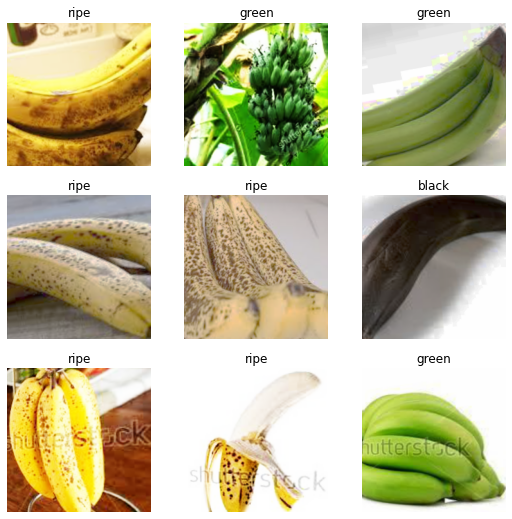

In [160]:
# Define some transforms and setup data bunch
#tfms = get_transforms(do_flip=True)
#data = ImageDataBunch.from_folder(path,train="train", ds_tfms=tfms, size=100, valid_pct=0.20)
#data

#Alternative Method using FastAI built-in ImageDataLoaders [use above for class]
bs = 64
# 
# # https://docs.fast.ai/vision.data#ImageDataLoaders.from_folder
dls = fva.ImageDataLoaders.from_folder(
    path, 
    item_tfms=fva.Resize(460), 
    bs=bs,
    valid_pct=0.33,
    batch_tfms=[*fva.aug_transforms(max_lighting=0.5, size=224, min_scale=0.65), fva.Normalize.from_stats(*fva.imagenet_stats)])
dls.show_batch(max_n=9, figsize=(9,9))

In [161]:
get_label_distribution(dls)

,train,valid,train_pct,valid_pct,labels
0,11,1,0.1375,0.026316,black
1,18,8,0.2250,0.210526,green
2,6,5,0.0750,0.131579,overripe
3,35,17,0.4375,0.447368,ripe
4,10,7,0.1250,0.184211,yellow


## Training

In [162]:
# Setup a CNN learner
learn = fva.cnn_learner(dls, fva.resnet50, metrics=fva.accuracy)
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,2.875385,2.704654,0.526316,00:02
1,2.810765,1.884710,0.578947,00:01
2,2.250974,1.415152,0.578947,00:02
3,1.809321,1.226897,0.631579,00:02
4,1.507056,1.094026,0.605263,00:02


SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.0002754228771664202)

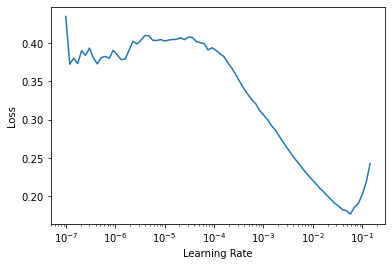

In [163]:
# Learning rate search
learn.lr_find()

In [164]:
# Run fit one cycle for 5 epochs
learn.fit_one_cycle(5,slice(1e-4,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.500596,1.004350,0.657895,00:02
1,0.421859,1.615322,0.684211,00:02
2,0.290272,1.963566,0.710526,00:01
3,0.224588,1.940185,0.710526,00:02
4,0.184711,1.664986,0.736842,00:02


In [165]:
learn.fit_one_cycle(5,slice(1e-4,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.060225,1.441143,0.736842,00:02
1,0.096830,1.446771,0.763158,00:02
2,0.087771,1.408748,0.763158,00:02
3,0.089679,1.309036,0.763158,00:02
4,0.079759,1.188982,0.763158,00:01


In [166]:
learn.freeze_to(-3)

In [167]:
learn.fit_one_cycle(5,slice(1e-4,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.032982,1.205886,0.736842,00:02
1,0.042979,9.194491,0.289474,00:02
2,0.275675,7.093943,0.552632,00:02
3,0.489891,4.780393,0.789474,00:01
4,0.410985,3.779800,0.815789,00:02


In [173]:
learn.fit_one_cycle(1,slice(1e-4,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.110469,1.817034,0.815789,00:02


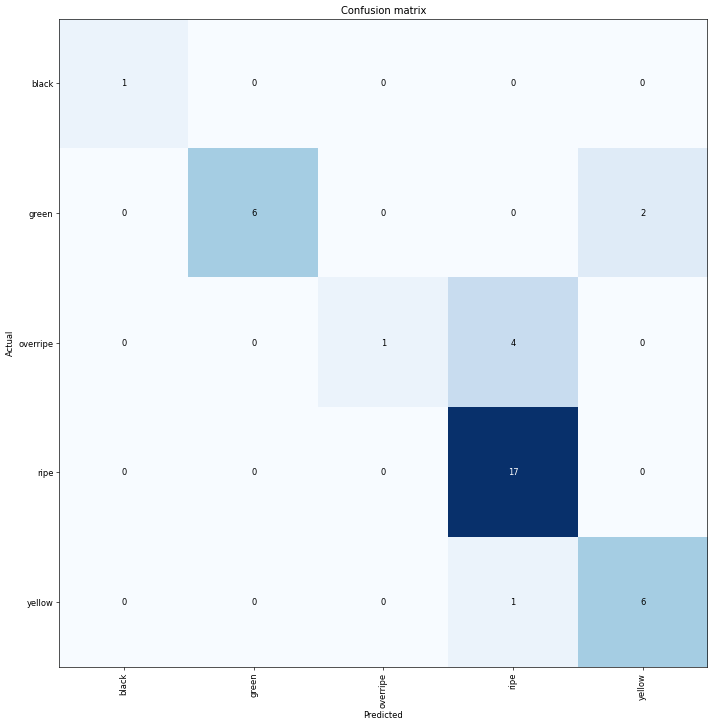

In [176]:
# Lets see how well we did ... 
interp = fva.ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(dls.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [177]:
interp.print_classification_report()

              precision    recall  f1-score   support

       black       1.00      1.00      1.00         1
       green       1.00      0.75      0.86         8
    overripe       1.00      0.20      0.33         5
        ripe       0.77      1.00      0.87        17
      yellow       0.75      0.86      0.80         7

    accuracy                           0.82        38
   macro avg       0.90      0.76      0.77        38
weighted avg       0.85      0.82      0.79        38



# Inference

In [178]:
# Download some sample images here .... 
command = googliser + \
                      " --o /tmp/banana_inference "+\
                      " --phrase \"ripe black yellow green bananas\" " + \
                      " --parallel 50 --upper-size 500000 --lower-size 2000 " + \
                      " -n 10 " + \
                      " --format jpg --timeout 15 --safesearch-off "
print(command)
!{command}

/home/cecuser/5050/aicoc-ai-immersion/FastAI/googliser/googliser.sh --o /tmp/banana_inference  --phrase "ripe black yellow green bananas"  --parallel 50 --upper-size 500000 --lower-size 2000  -n 10  --format jpg --timeout 15 --safesearch-off 
 googliser.sh v:200212 PID:26381

   Google: 0/10 web pages OK, 1/10 are in progres0/10 web pages OK, 2/10 are in progres0/10 web pages OK, 3/10 are in progres0/10 web pages OK, 4/10 are in progres0/10 web pages OK, 5/10 are in progres0/10 web pages OK, 6/10 are in progres0/10 web pages OK, 7/10 are in progres0/10 web pages OK, 8/10 are in progres0/10 web pages OK, 9/10 are in progres0/10 web pages OK, 10/10 are in progress10 web pages OK                         
    links: 91 
 download: 0/10 images OK0/10 images OK, 1/50 are in progress0/10 images OK, 2/50 are in progress0/10 images OK, 3/50 are in progress0/10 images OK, 4/50 are in progress0/10 images OK, 5/50 are in progress0/10 images OK, 6/50 are in progress0/10 images OK, 6/50 are in progr

In [180]:
# get rid of malformed images manually .

command = cfg["jpeginfo"] + " -c /tmp/banana_inference"
!{command}

#!ls /tmp/banana_inference
#!rm /tmp/banana_inference/image\(0020\).jpg

('yellow', tensor(4), tensor([1.2299e-06, 1.3116e-07, 3.9744e-07, 1.4464e-04, 9.9985e-01]))


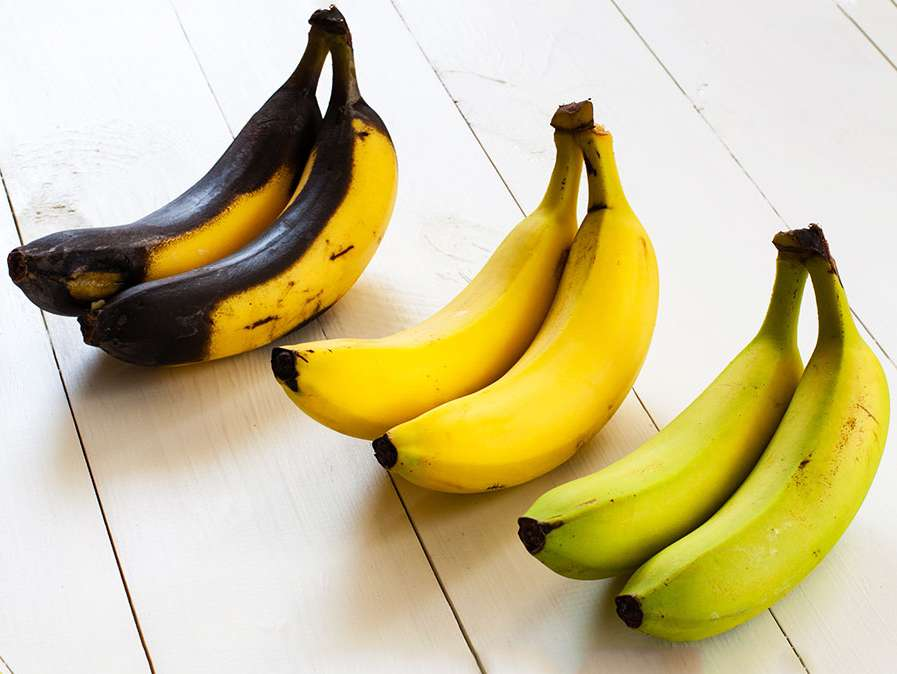

('green', tensor(1), tensor([6.7917e-02, 9.3075e-01, 4.1509e-05, 5.4877e-09, 1.2966e-03]))


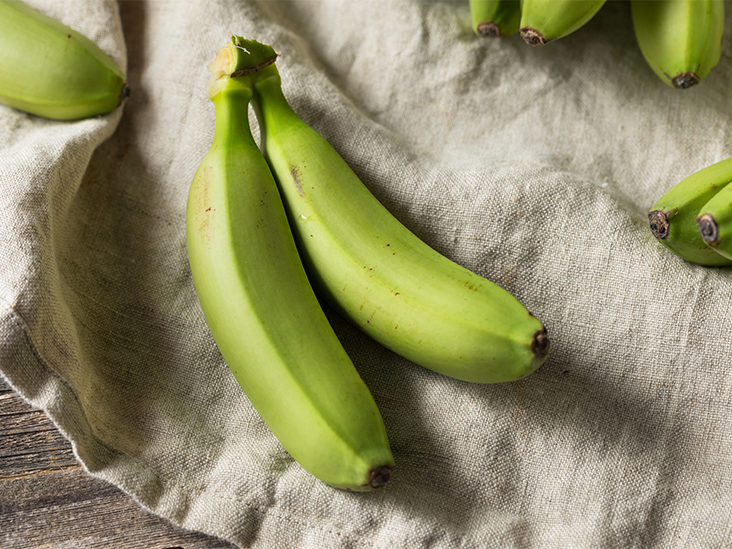

('yellow', tensor(4), tensor([6.8652e-06, 1.2835e-02, 1.6898e-04, 1.5483e-03, 9.8544e-01]))


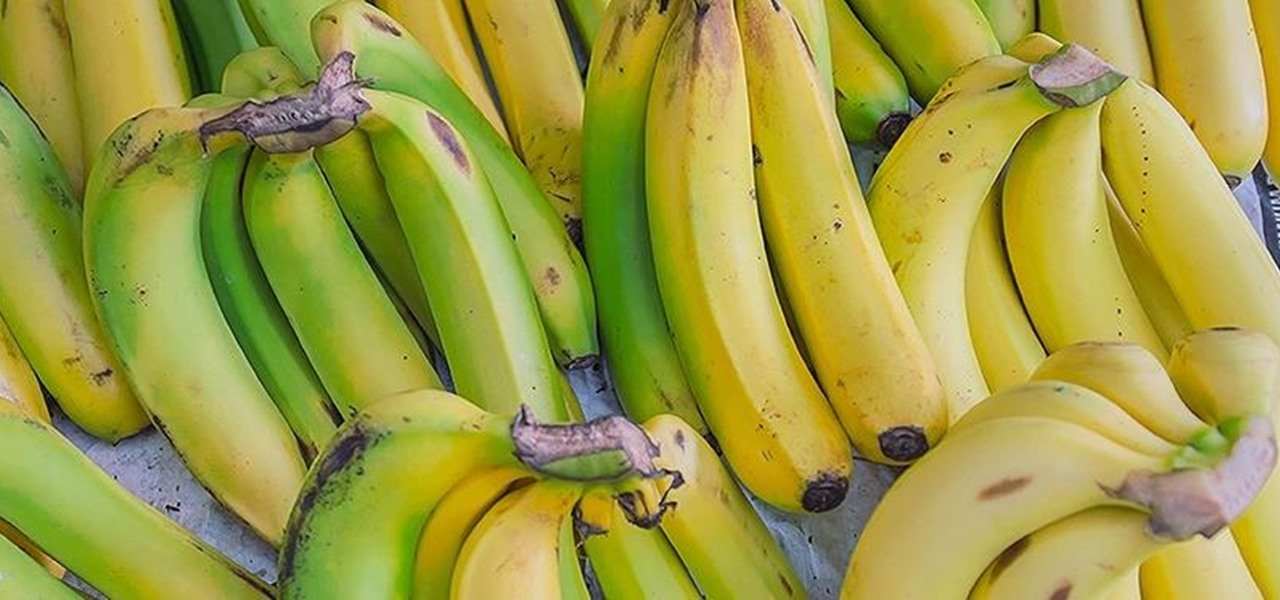

('yellow', tensor(4), tensor([1.0984e-03, 3.4166e-03, 2.1150e-05, 1.1307e-07, 9.9546e-01]))


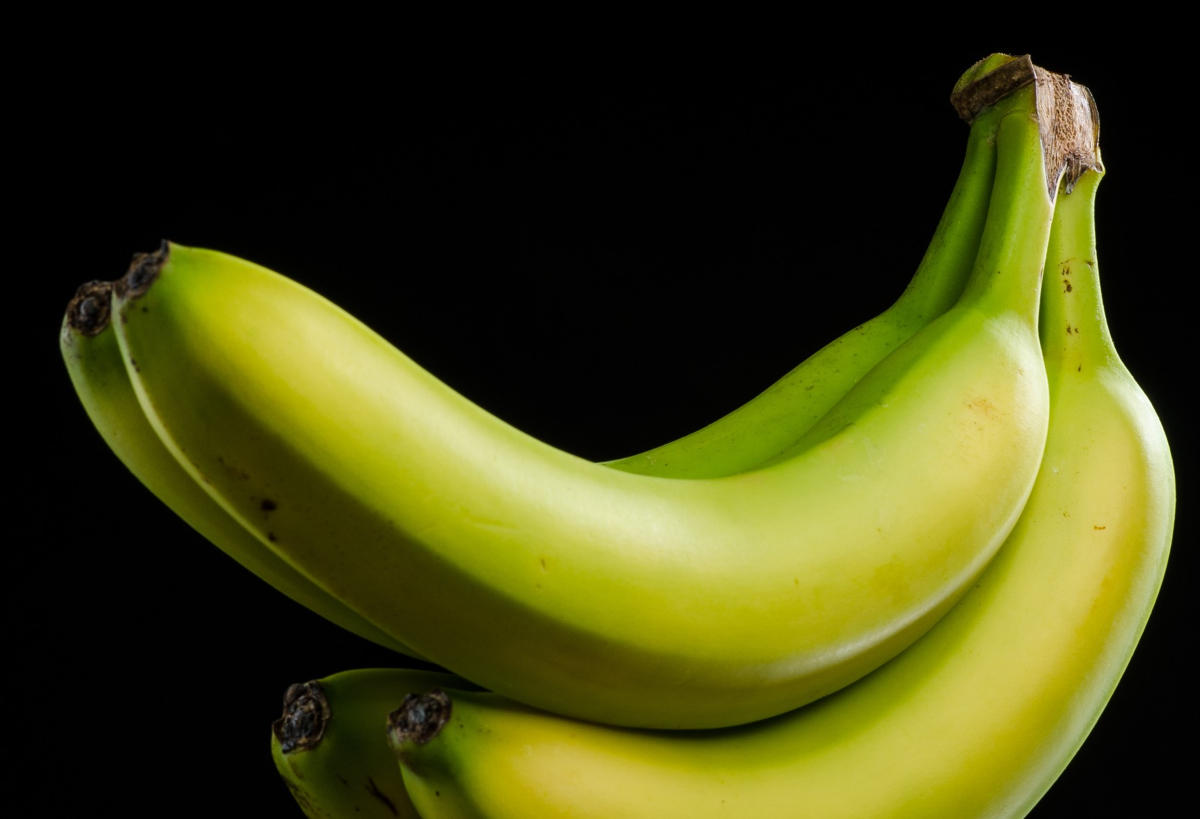

('ripe', tensor(3), tensor([1.5256e-06, 1.2058e-05, 3.9491e-05, 7.2886e-01, 2.7109e-01]))


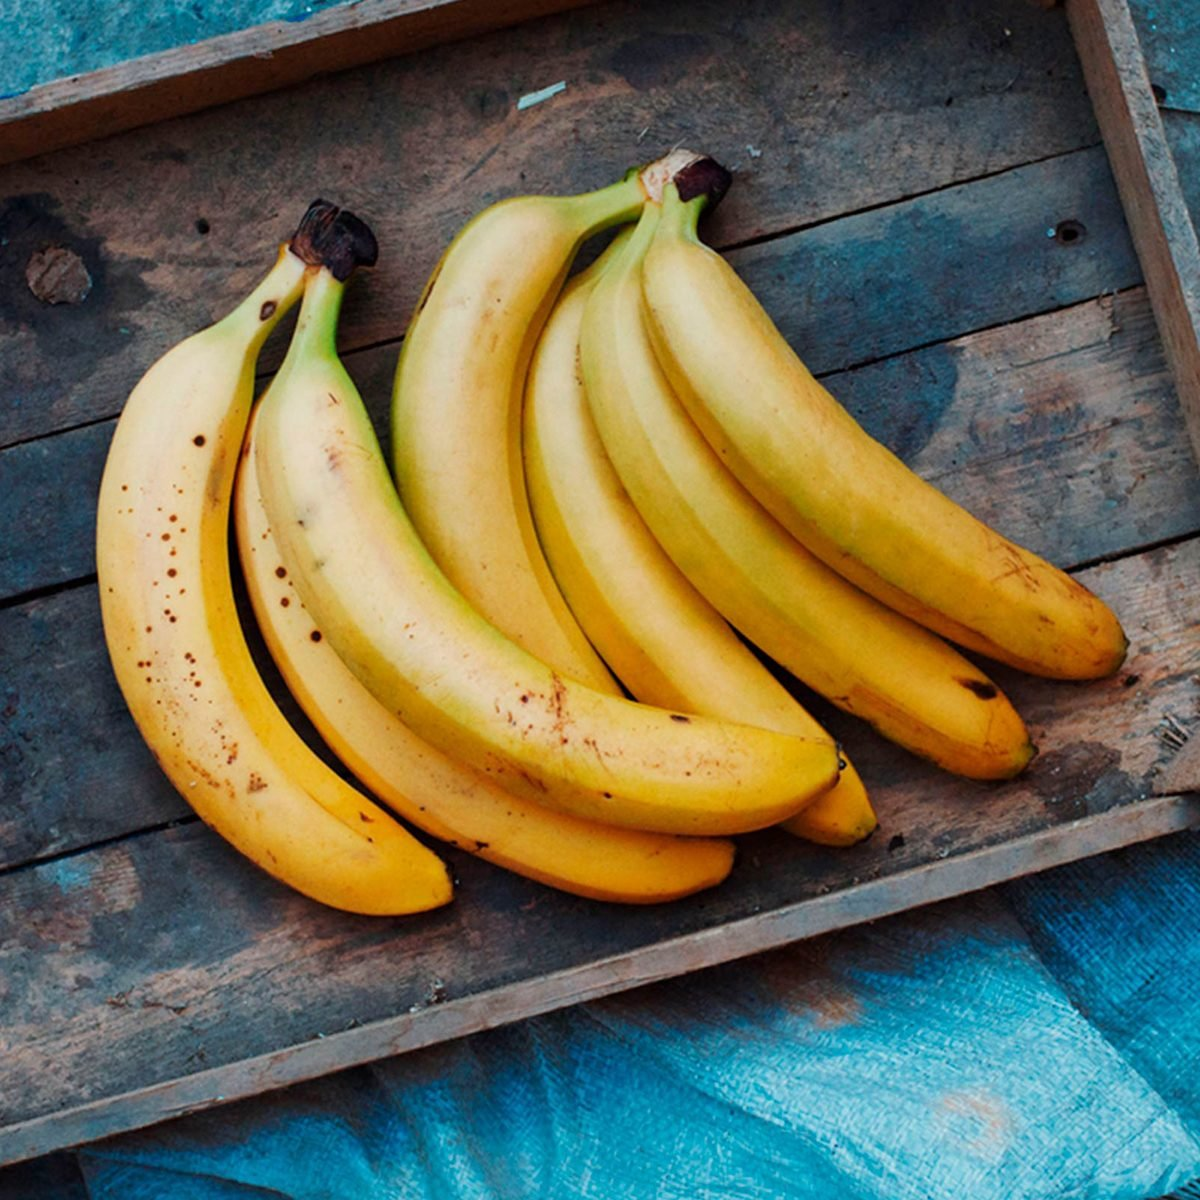

('yellow', tensor(4), tensor([1.1199e-05, 2.6031e-03, 9.5187e-03, 6.0306e-07, 9.8787e-01]))


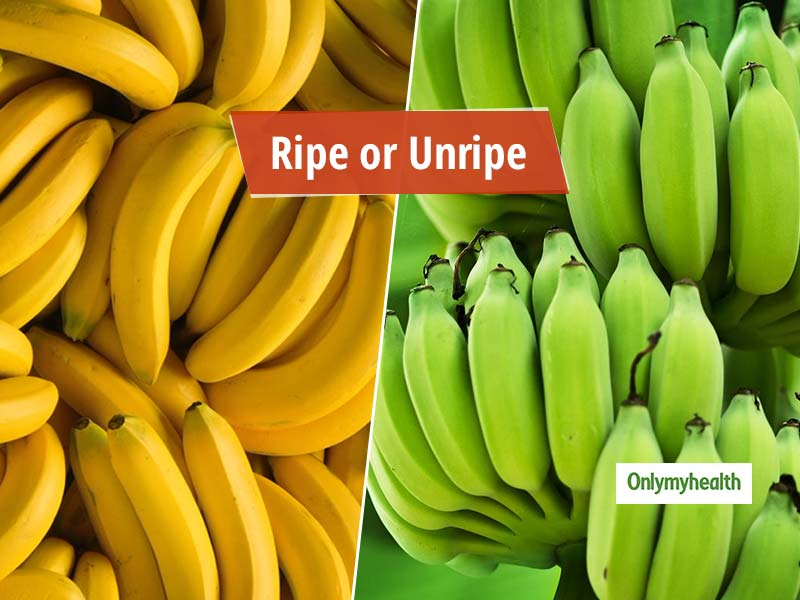

('ripe', tensor(3), tensor([4.2793e-07, 3.1569e-04, 1.9400e-06, 9.9951e-01, 1.7029e-04]))


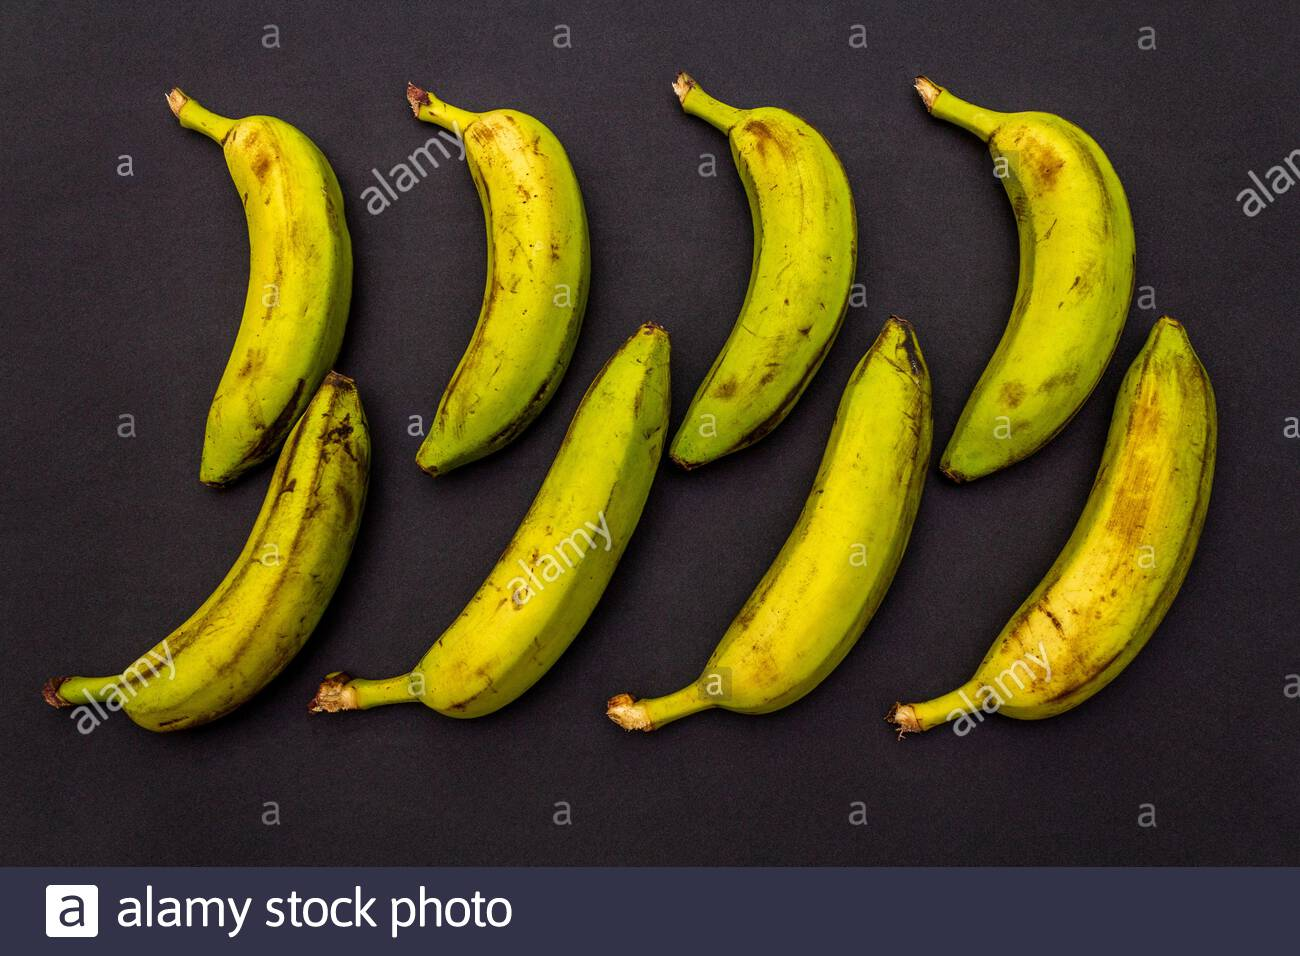

('green', tensor(1), tensor([5.2220e-02, 6.9970e-01, 2.9589e-03, 3.2700e-05, 2.4509e-01]))


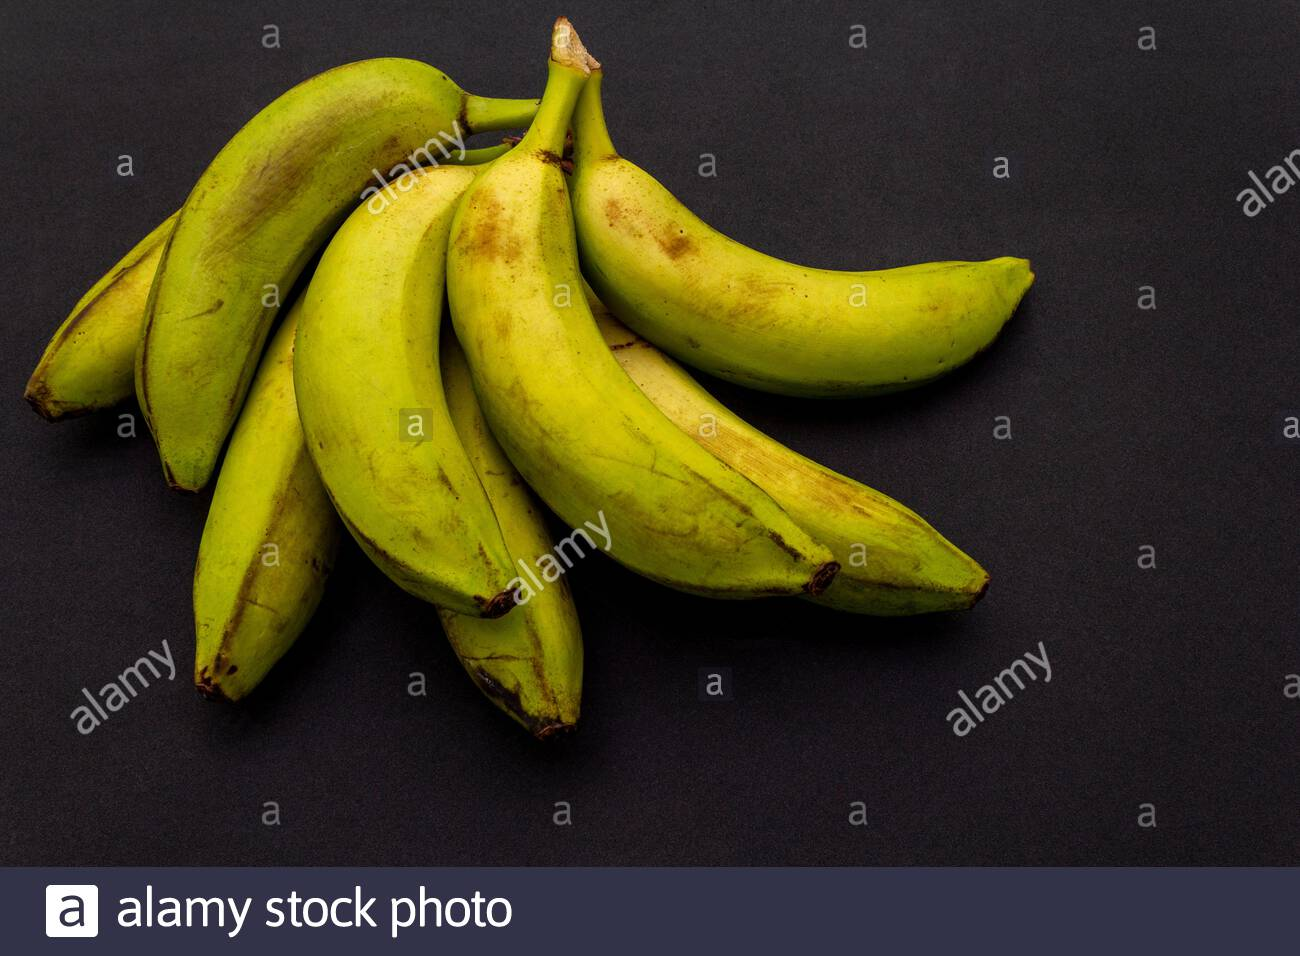

('green', tensor(1), tensor([3.2012e-04, 9.3319e-01, 2.1877e-02, 3.2148e-05, 4.4576e-02]))


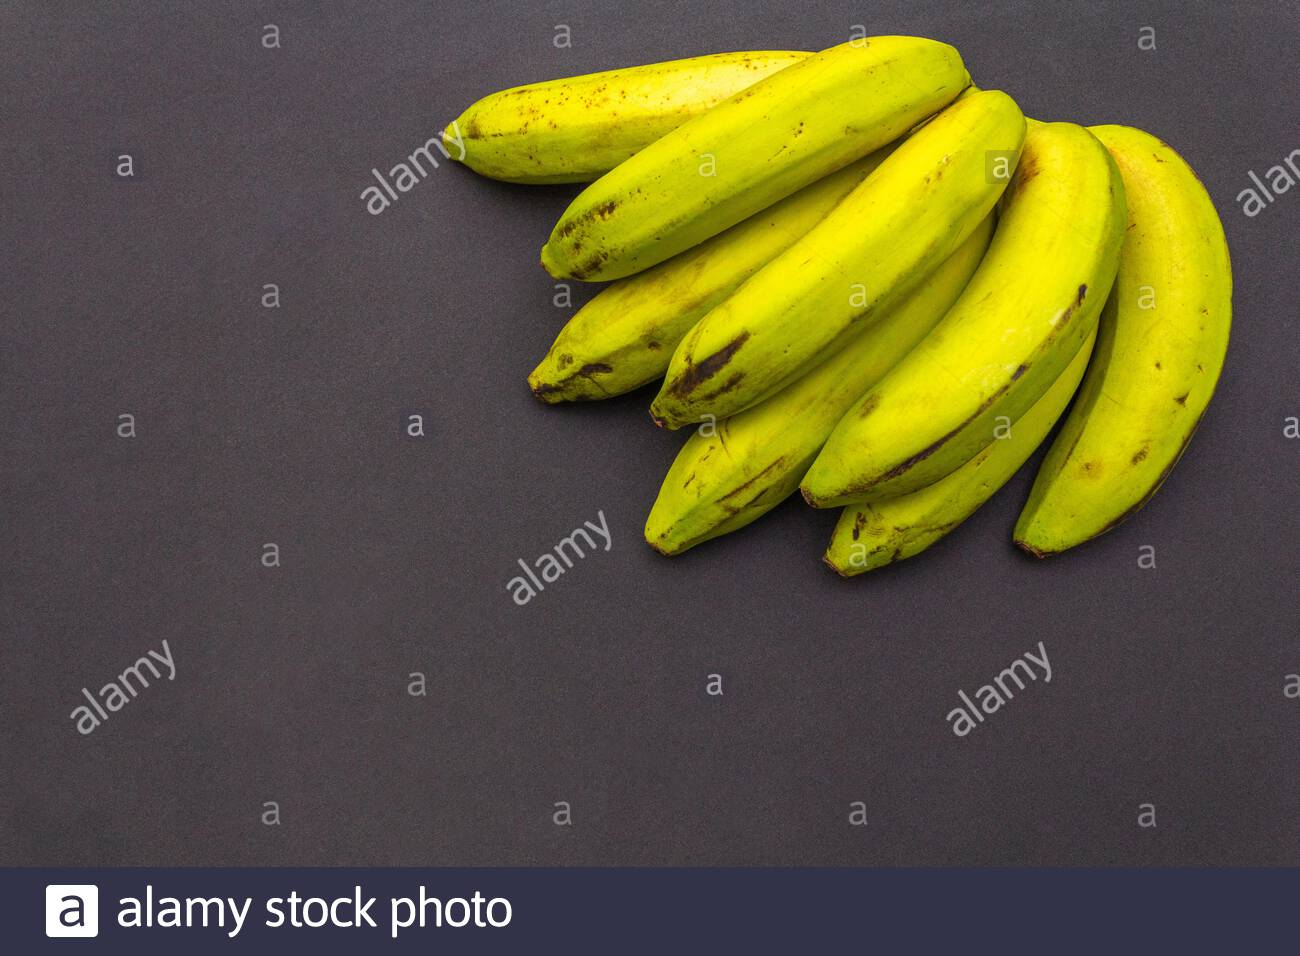

('ripe', tensor(3), tensor([2.0584e-04, 2.3251e-05, 1.1942e-05, 9.5218e-01, 4.7579e-02]))


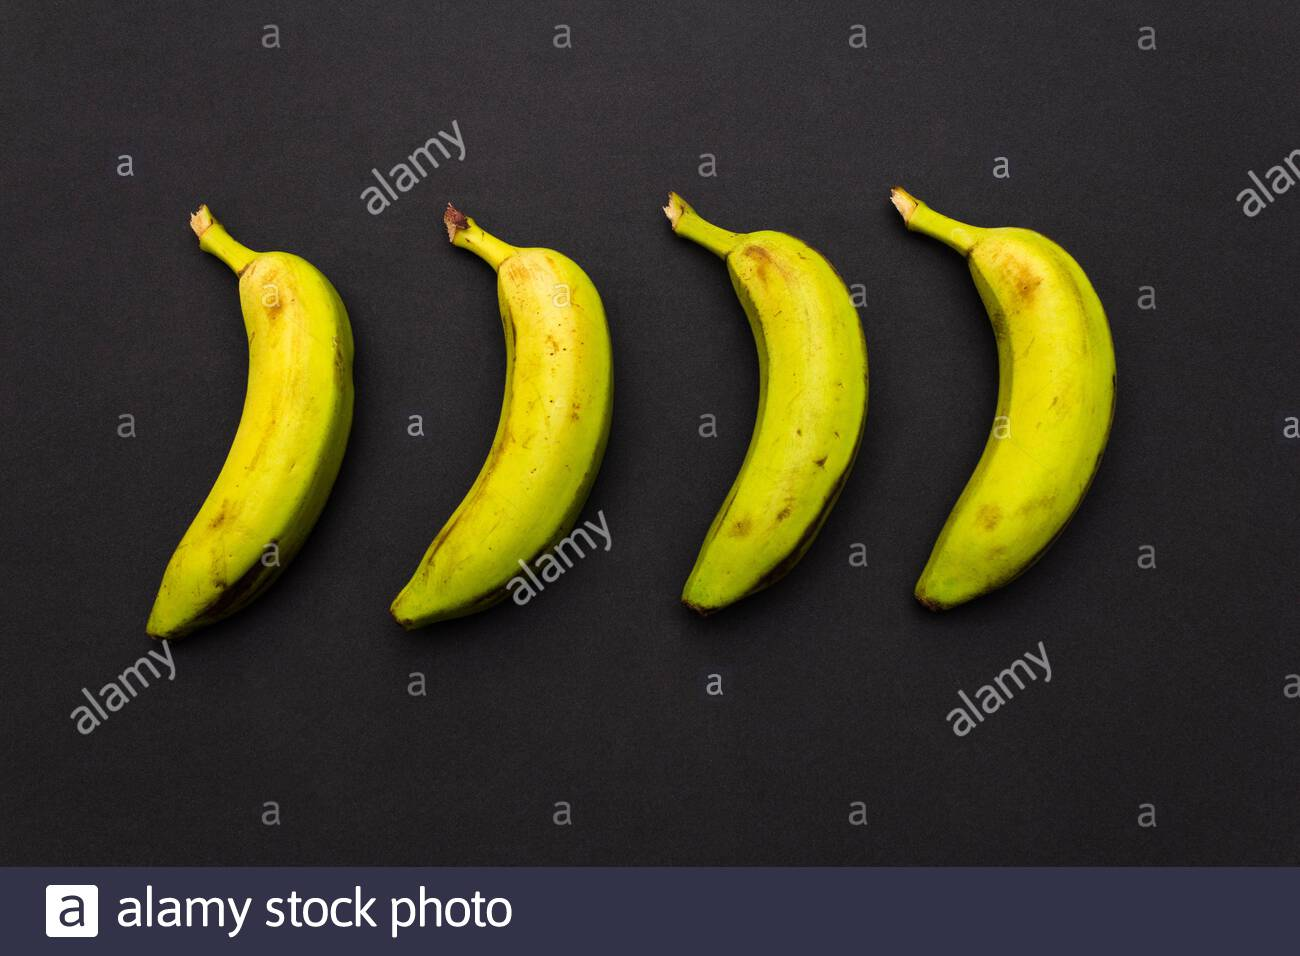

In [192]:
# Inference on your list of images .. 
import glob
import PIL
from IPython.display import Image 

files = glob.glob("/tmp/banana_inference/image*.jpg")

def single_inference(img_path) :
    
    # img = open_image(img_path)
    #img = PIL.Image.open(img_path)
    prediction=learn.predict(img_path)
    print(prediction)
    #img_cls = data.classes[prediction[1].numpy()]
    #img.show(title=img_cls)
    pil_img = Image(filename=img_path)
    display(pil_img)

for my_img in files :
    single_inference(Path(my_img))

Congratulations, you can now build a pretty darn good classifier in less than one hour!

Credits 
* FastAI Team
* Bob Chesebrough / Dustin VanStee - AICoC Data science team